# Audit & EDA 


In [24]:
import re
import numpy as np
import pandas as pd

from pathlib import Path
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [25]:
data_path = Path("../data/raw")


TRAIN_PATH = data_path / "train.csv"
TEST_PATH  = data_path / "test.csv"
STORES_PATH = data_path / "stores.csv"
TRANSACTIONS_PATH = data_path / "transactions.csv"
OIL_PATH = data_path / "oil.csv"
HOLIDAYS_PATH = data_path / "holidays_events.csv"
SUBMISSION_PATH = data_path / "sample_submission.csv"

In [26]:



def assert_unique(df, cols, name):
    dup = df.duplicated(cols).sum()
    assert dup == 0, f"[{name}] Doublons détectés sur {cols}: {dup}"

def print_header(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)

In [27]:

dtypes_train = {
    "id": "int32",
    "store_nbr": "int16",
    "family": "category",
    "onpromotion": "int16",
    "sales": "float32",
}
train = pd.read_csv(TRAIN_PATH, parse_dates=["date"], dtype=dtypes_train)



In [28]:
dtypes_test = {
    "id": "int32",
    "store_nbr": "int16",
    "family": "category",
    "onpromotion": "int16",
}
test = pd.read_csv(TEST_PATH, parse_dates=["date"], dtype=dtypes_test)

stores = pd.read_csv(STORES_PATH)
transactions = pd.read_csv(TRANSACTIONS_PATH, parse_dates=["date"], dtype={"store_nbr":"int16", "transactions":"int32"})
oil = pd.read_csv(OIL_PATH, parse_dates=["date"])
holidays = pd.read_csv(HOLIDAYS_PATH, parse_dates=["date"])
sample_sub = pd.read_csv(SUBMISSION_PATH)



In [29]:
print_header("Aperçu des shapes")
display(pd.DataFrame({
    "file": ["train","test","stores","transactions","oil","holidays","sample_submission"],
    "rows": [len(train), len(test), len(stores), len(transactions), len(oil), len(holidays), len(sample_sub)],
    "cols": [train.shape[1], test.shape[1], stores.shape[1], transactions.shape[1], oil.shape[1], holidays.shape[1], sample_sub.shape[1]],
}))


Aperçu des shapes


,file,rows,cols
0,train,3000888,6
1,test,28512,5
2,stores,54,5
3,transactions,83488,3
4,oil,1218,2
5,holidays,350,6
6,sample_submission,28512,2


## 1) Audit “anti-erreurs” (types, clés, doublons, trous, NA)

In [30]:
print_header("Audit 1/4 — Types, clés, doublons")

# Types
assert pd.api.types.is_datetime64_any_dtype(train["date"]), "train.date n'est pas en datetime"
assert pd.api.types.is_datetime64_any_dtype(test["date"]), "test.date n'est pas en datetime"
assert pd.api.types.is_datetime64_any_dtype(transactions["date"]), "transactions.date n'est pas en datetime"
assert pd.api.types.is_datetime64_any_dtype(oil["date"]), "oil.date n'est pas en datetime"
assert pd.api.types.is_datetime64_any_dtype(holidays["date"]), "holidays.date n'est pas en datetime"




Audit 1/4 — Types, clés, doublons


In [31]:
# Clés attendues
assert_unique(train, ["date","store_nbr","family"], "train")
assert_unique(test, ["date","store_nbr","family"], "test")
assert_unique(transactions, ["date","store_nbr"], "transactions")
assert_unique(oil, ["date"], "oil")

# Cohérence ID
assert train["id"].is_unique, "train.id n'est pas unique"
assert test["id"].is_unique, "test.id n'est pas unique"
assert sample_sub["id"].is_unique, "sample_submission.id n'est pas unique"



In [32]:

print_header("Audit 2/4 — Périodes couvertes et cardinalités")
def date_span(df, col="date"):
    return df[col].min(), df[col].max()

train_min, train_max = date_span(train)
test_min, test_max = date_span(test)
print(f"Train: {train_min.date()} → {train_max.date()}  (n_days={train['date'].nunique()})")
print(f"Test : {test_min.date()} → {test_max.date()}  (n_days={test['date'].nunique()})")

n_stores = train["store_nbr"].nunique()
n_family = train["family"].nunique()
print(f"Stores uniques (train): {n_stores}")
print(f"Familles uniques (train): {n_family}")

print_header("Audit 3/4 — Valeurs manquantes")
na_summary = pd.DataFrame({
    "train_na": train.isna().sum(),
    "test_na": test.isna().sum().reindex(train.columns, fill_value=np.nan),
})
display(na_summary)



Audit 2/4 — Périodes couvertes et cardinalités
Train: 2013-01-01 → 2017-08-15  (n_days=1684)
Test : 2017-08-16 → 2017-08-31  (n_days=16)
Stores uniques (train): 54
Familles uniques (train): 33

Audit 3/4 — Valeurs manquantes


,train_na,test_na
id,0,0.0
date,0,0.0
store_nbr,0,0.0
family,0,0.0
sales,0,NaN
onpromotion,0,0.0


In [33]:

print("NA oil.dcoilwtico:", oil["dcoilwtico"].isna().sum())
print_header("Audit 4/4 — Jours manquants (train / transactions)")
full_train_days = pd.date_range(train_min, train_max, freq="D")
missing_train_days = full_train_days.difference(pd.DatetimeIndex(train["date"].unique()))
print("Nombre de jours manquants dans train:", len(missing_train_days))
if len(missing_train_days) > 0:
    print("Exemples:", list(missing_train_days[:10].date))

tx_min, tx_max = transactions["date"].min(), transactions["date"].max()
full_tx_days = pd.date_range(tx_min, tx_max, freq="D")
missing_tx_days = full_tx_days.difference(pd.DatetimeIndex(transactions["date"].unique()))
print("Nombre de jours manquants dans transactions:", len(missing_tx_days))
if len(missing_tx_days) > 0:
    print("Exemples:", list(missing_tx_days[:10].date))

NA oil.dcoilwtico: 43

Audit 4/4 — Jours manquants (train / transactions)
Nombre de jours manquants dans train: 4
Exemples: [datetime.date(2013, 12, 25), datetime.date(2014, 12, 25), datetime.date(2015, 12, 25), datetime.date(2016, 12, 25)]
Nombre de jours manquants dans transactions: 6
Exemples: [datetime.date(2013, 12, 25), datetime.date(2014, 12, 25), datetime.date(2015, 12, 25), datetime.date(2016, 1, 1), datetime.date(2016, 1, 3), datetime.date(2016, 12, 25)]


## 2) EDA minimale mais utile (distribution, zéros, intermittence)


EDA — Distribution des ventes et sparsité (zéros)


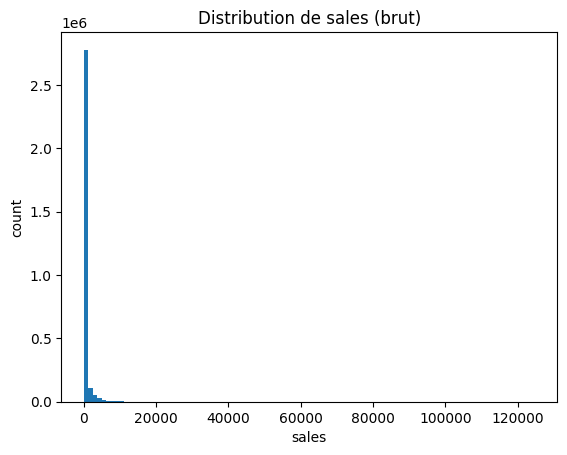

In [34]:
print_header("EDA — Distribution des ventes et sparsité (zéros)")

# Histogramme ventes (brut + log1p)
sales = train["sales"].astype("float64")

plt.figure()
plt.hist(sales, bins=100)
plt.title("Distribution de sales (brut)")
plt.xlabel("sales")
plt.ylabel("count")
plt.show()


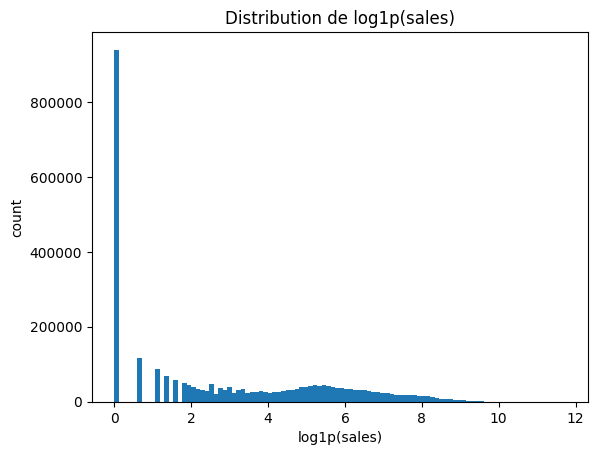

In [35]:

plt.figure()
plt.hist(np.log1p(sales), bins=100)
plt.title("Distribution de log1p(sales)")
plt.xlabel("log1p(sales)")
plt.ylabel("count")
plt.show()


In [36]:

zero_rate = (train["sales"] == 0).mean()
print(f"Taux global de zéros dans train: {zero_rate:.4f} ({zero_rate*100:.2f}%)")

# Zéros par family
zero_by_family = (
    train.assign(is_zero=(train["sales"]==0).astype("int8"))
         .groupby("family", observed=True)["is_zero"]
         .mean()
         .sort_values(ascending=False)
         .to_frame("pct_zero")
)
display(zero_by_family.head(20))


Taux global de zéros dans train: 0.3130 (31.30%)


,pct_zero
family,
BOOKS,0.969550
BABY CARE,0.941310
SCHOOL AND OFFICE SUPPLIES,0.740829
HOME APPLIANCES,0.735176
LADIESWEAR,0.598465
MAGAZINES,0.565387
PET SUPPLIES,0.546153
HARDWARE,0.478622
LAWN AND GARDEN,0.467846


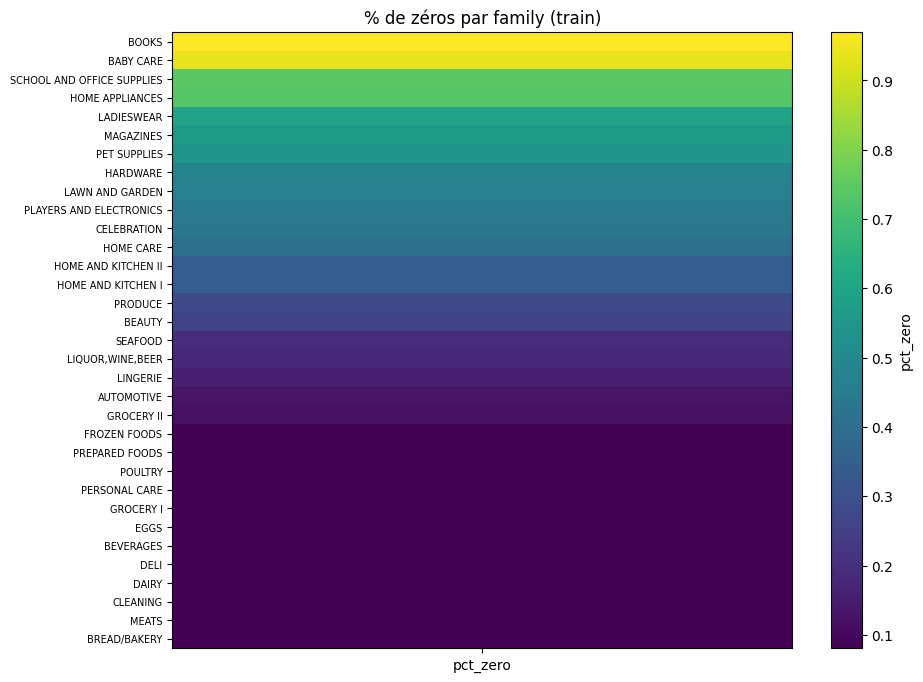

In [37]:

# Heatmap simple : % zéros par family (barplot "heat-like")
plt.figure(figsize=(10, 8))
vals = zero_by_family["pct_zero"].values
plt.imshow(vals.reshape(-1,1), aspect="auto")
plt.yticks(np.arange(len(zero_by_family)), zero_by_family.index, fontsize=7)
plt.xticks([0], ["pct_zero"])
plt.title("% de zéros par family (train)")
plt.colorbar(label="pct_zero")
plt.show()


In [38]:

print_header("EDA — Intermittence par série (store×family)")

# On calcule des stats par série
grp = train.groupby(["store_nbr","family"], observed=True)["sales"]
series_stats = grp.agg(
    n_obs="size",
    pct_zero=lambda s: float((s==0).mean()),
    mean_sales="mean",
    std_sales="std",
    sum_sales="sum",
)
series_stats["cv2_sales"] = (series_stats["std_sales"] / series_stats["mean_sales"]).replace([np.inf, -np.inf], np.nan) ** 2
series_stats = series_stats.reset_index()

always_zero = (series_stats["sum_sales"] == 0).sum()
print(f"Nombre de séries store×family toujours à zéro sur toute la période train: {always_zero}")

display(series_stats.sort_values("pct_zero", ascending=False).head(20))



EDA — Intermittence par série (store×family)
Nombre de séries store×family toujours à zéro sur toute la période train: 53


,store_nbr,family,n_obs,pct_zero,mean_sales,std_sales,sum_sales,cv2_sales
1753,54,BOOKS,1684,1.0,0.0,0.0,0.0,NaN
1618,50,BABY CARE,1684,1.0,0.0,0.0,0.0,NaN
1585,49,BABY CARE,1684,1.0,0.0,0.0,0.0,NaN
1519,47,BABY CARE,1684,1.0,0.0,0.0,0.0,NaN
1486,46,BABY CARE,1684,1.0,0.0,0.0,0.0,NaN
1552,48,BABY CARE,1684,1.0,0.0,0.0,0.0,NaN
1687,52,BOOKS,1684,1.0,0.0,0.0,0.0,NaN
1453,45,BABY CARE,1684,1.0,0.0,0.0,0.0,NaN
1420,44,BABY CARE,1684,1.0,0.0,0.0,0.0,NaN
1390,43,BOOKS,1684,1.0,0.0,0.0,0.0,NaN


## 3) Holidays : pourquoi ça duplique et comment construire des features correctes (store-aware)

In [39]:
print_header("Prétraitement Holidays — éviter la duplication et créer des features store-aware")

# 1) Diagnostic duplication par date
dup_per_date = holidays.groupby("date").size().sort_values(ascending=False)
print("Max lignes holidays sur une même date:", int(dup_per_date.iloc[0]))
display(dup_per_date.head(10).to_frame("n_rows"))

# 2) Construire une table date×store avec flags:
#    - National : s'applique à tous les stores
#    - Regional : s'applique aux stores dont state == locale_name
#    - Local    : s'applique aux stores dont city == locale_name

# Normaliser colonnes stores pour merge
stores_small = stores[["store_nbr","city","state"]].copy()
stores_small["store_nbr"] = stores_small["store_nbr"].astype("int16")

# On isole les types utiles
hol = holidays.copy()
hol["transferred"] = hol["transferred"].astype("bool")

# On va construire un mapping "holiday_row -> affected stores"
national = hol[hol["locale"].str.lower() == "national"].copy()
regional = hol[hol["locale"].str.lower() == "regional"].copy()
local = hol[hol["locale"].str.lower() == "local"].copy()

# National: cross join date -> tous stores
nat_exp = national[["date","type","transferred"]].assign(key=1).merge(stores_small.assign(key=1), on="key").drop(columns=["key"])

# Regional: join sur state
reg_exp = regional[["date","type","locale_name","transferred"]].merge(
    stores_small, left_on="locale_name", right_on="state", how="inner"
)

# Local: join sur city
loc_exp = local[["date","type","locale_name","transferred"]].merge(
    stores_small, left_on="locale_name", right_on="city", how="inner"
)

hol_expanded = pd.concat([nat_exp, reg_exp, loc_exp], ignore_index=True)
hol_expanded["type_norm"] = hol_expanded["type"].astype(str).str.lower()

# Agrégation par date×store
hol_store = hol_expanded.groupby(["date","store_nbr"], as_index=False).agg(
    n_holidays=("type_norm", "size"),
    has_holiday=("type_norm", lambda s: int((s=="holiday").any())),
    has_event=("type_norm", lambda s: int((s=="event").any())),
    has_work_day=("type_norm", lambda s: int((s=="work day").any())),
    n_transferred=("transferred", "sum"),
)
hol_store["has_any_special_day"] = ((hol_store["n_holidays"] > 0).astype("int8"))

display(hol_store.head())
print("hol_store rows:", len(hol_store), "| distinct dates:", hol_store["date"].nunique(), "| distinct stores:", hol_store["store_nbr"].nunique())


Prétraitement Holidays — éviter la duplication et créer des features store-aware
Max lignes holidays sur une même date: 4


,n_rows
date,
2014-06-25,4
2012-06-25,3
2017-06-25,3
2013-06-25,3
2015-06-25,3
2016-06-25,3
2012-07-03,2
2013-12-22,2
2012-12-22,2


,date,store_nbr,n_holidays,has_holiday,has_event,has_work_day,n_transferred,has_any_special_day
0,2012-03-02,52,1,1,0,0,0,1
1,2012-03-02,53,1,1,0,0,0,1
2,2012-04-01,12,1,1,0,0,0,1
3,2012-04-01,13,1,1,0,0,0,1
4,2012-04-12,37,1,1,0,0,0,1


hol_store rows: 9601 | distinct dates: 312 | distinct stores: 54


In [40]:

print_header("EDA — Intermittence par série (store×family)")

# On calcule des stats par série
grp = train.groupby(["store_nbr","family"], observed=True)["sales"]
series_stats = grp.agg(
    n_obs="size",
    pct_zero=lambda s: float((s==0).mean()),
    mean_sales="mean",
    std_sales="std",
    sum_sales="sum",
)
series_stats["cv2_sales"] = (series_stats["std_sales"] / series_stats["mean_sales"]).replace([np.inf, -np.inf], np.nan) ** 2
series_stats = series_stats.reset_index()

always_zero = (series_stats["sum_sales"] == 0).sum()
print(f"Nombre de séries store×family toujours à zéro sur toute la période train: {always_zero}")

display(series_stats.sort_values("pct_zero", ascending=False).head(20))


print_header("EDA — ADI (Average Demand Interval) et CV² (sur demandes non-nulles)")

def adi_and_cv2_nonzero(df_one_series):
    # df_one_series: DataFrame contenant date + sales d'une série
    s = df_one_series.sort_values("date")[["date","sales"]]
    nz = s[s["sales"] > 0]
    if len(nz) < 2:
        return np.nan, np.nan
    # intervalles en jours entre ventes non nulles
    intervals = nz["date"].diff().dt.days.dropna()
    adi = intervals.mean() if len(intervals) else np.nan
    # CV² sur tailles non-nulles
    sizes = nz["sales"].astype("float64").values
    m = sizes.mean()
    if m <= 0:
        cv2 = np.nan
    else:
        cv2 = (sizes.std(ddof=1) / m) ** 2 if len(sizes) > 1 else np.nan
    return float(adi), float(cv2)

# Calcul sur un échantillon pour rester rapide (option: sur tout, c'est encore ok mais plus long)
# Ici on calcule sur tout mais en limitant le coût: on ne garde que date/sales et on fait apply groupby.
tmp = train[["date","store_nbr","family","sales"]]
adi_cv2 = tmp.groupby(["store_nbr","family"], observed=True).apply(adi_and_cv2_nonzero)
adi_cv2 = pd.DataFrame(adi_cv2.tolist(), index=adi_cv2.index, columns=["adi_days","cv2_nonzero"]).reset_index()

series_profile = series_stats.merge(adi_cv2, on=["store_nbr","family"], how="left")
display(series_profile.sort_values(["pct_zero","adi_days"], ascending=False).head(20))

# Petites stats globales sur l'intermittence
print("Pct_zero (median):", float(series_profile["pct_zero"].median()))
print("ADI_days (median, hors NA):", float(series_profile["adi_days"].dropna().median()))


EDA — Intermittence par série (store×family)
Nombre de séries store×family toujours à zéro sur toute la période train: 53


,store_nbr,family,n_obs,pct_zero,mean_sales,std_sales,sum_sales,cv2_sales
1753,54,BOOKS,1684,1.0,0.0,0.0,0.0,NaN
1618,50,BABY CARE,1684,1.0,0.0,0.0,0.0,NaN
1585,49,BABY CARE,1684,1.0,0.0,0.0,0.0,NaN
1519,47,BABY CARE,1684,1.0,0.0,0.0,0.0,NaN
1486,46,BABY CARE,1684,1.0,0.0,0.0,0.0,NaN
1552,48,BABY CARE,1684,1.0,0.0,0.0,0.0,NaN
1687,52,BOOKS,1684,1.0,0.0,0.0,0.0,NaN
1453,45,BABY CARE,1684,1.0,0.0,0.0,0.0,NaN
1420,44,BABY CARE,1684,1.0,0.0,0.0,0.0,NaN
1390,43,BOOKS,1684,1.0,0.0,0.0,0.0,NaN



EDA — ADI (Average Demand Interval) et CV² (sur demandes non-nulles)


C:\Users\gouab\AppData\Local\Temp\ipykernel_15980\1108181680.py:44: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adi_cv2 = tmp.groupby(["store_nbr","family"], observed=True).apply(adi_and_cv2_nonzero)


,store_nbr,family,n_obs,pct_zero,mean_sales,std_sales,sum_sales,cv2_sales,adi_days,cv2_nonzero
1,1,BABY CARE,1684,1.0,0.0,0.0,0.0,NaN,NaN,NaN
268,9,BOOKS,1684,1.0,0.0,0.0,0.0,NaN,NaN,NaN
301,10,BOOKS,1684,1.0,0.0,0.0,0.0,NaN,NaN,NaN
334,11,BOOKS,1684,1.0,0.0,0.0,0.0,NaN,NaN,NaN
367,12,BOOKS,1684,1.0,0.0,0.0,0.0,NaN,NaN,NaN
397,13,BABY CARE,1684,1.0,0.0,0.0,0.0,NaN,NaN,NaN
400,13,BOOKS,1684,1.0,0.0,0.0,0.0,NaN,NaN,NaN
433,14,BOOKS,1684,1.0,0.0,0.0,0.0,NaN,NaN,NaN
449,14,LAWN AND GARDEN,1684,1.0,0.0,0.0,0.0,NaN,NaN,NaN
466,15,BOOKS,1684,1.0,0.0,0.0,0.0,NaN,NaN,NaN


Pct_zero (median): 0.30641330166270786
ADI_days (median, hors NA): 1.069118579581484


## 4) Oil : imputation (forward-fill puis back-fill)

In [41]:
print_header("Prétraitement Oil — imputation forward-fill (puis back-fill si besoin)")

oil_sorted = oil.sort_values("date").copy()
oil_sorted["dcoilwtico"] = oil_sorted["dcoilwtico"].astype("float64")

na_before = int(oil_sorted["dcoilwtico"].isna().sum())
oil_sorted["dcoilwtico_ffill"] = oil_sorted["dcoilwtico"].ffill()
oil_sorted["dcoilwtico_ffill"] = oil_sorted["dcoilwtico_ffill"].bfill()
na_after = int(oil_sorted["dcoilwtico_ffill"].isna().sum())

print("NA avant:", na_before, "| NA après ffill+bfill:", na_after)
display(oil_sorted.head(10))


Prétraitement Oil — imputation forward-fill (puis back-fill si besoin)
NA avant: 43 | NA après ffill+bfill: 0


,date,dcoilwtico,dcoilwtico_ffill
0,2013-01-01,NaN,93.14
1,2013-01-02,93.14,93.14
2,2013-01-03,92.97,92.97
3,2013-01-04,93.12,93.12
4,2013-01-07,93.20,93.20
5,2013-01-08,93.21,93.21
6,2013-01-09,93.08,93.08
7,2013-01-10,93.81,93.81
8,2013-01-11,93.60,93.60
9,2013-01-14,94.27,94.27


## 5) Construction de la table canonique DAILY (train/test)

In [42]:
print_header("Construction table canonique DAILY (train + test séparés)")

# Préparer oil final
oil_feat = oil_sorted[["date","dcoilwtico_ffill"]].rename(columns={"dcoilwtico_ffill":"dcoilwtico"}).copy()

# Transactions (clés propres)
tx = transactions.copy()

# Stores
stores_feat = stores.copy()
stores_feat["store_nbr"] = stores_feat["store_nbr"].astype("int16")

def add_calendar_features(df):
    df = df.copy()
    df["day_of_week"] = df["date"].dt.dayofweek.astype("int8")
    df["weekofyear"] = df["date"].dt.isocalendar().week.astype("int16")
    df["month"] = df["date"].dt.month.astype("int8")
    df["year"] = df["date"].dt.year.astype("int16")
    df["is_weekend"] = (df["day_of_week"] >= 5).astype("int8")
    # payday proxy: 15 ou dernier jour du mois
    df["day"] = df["date"].dt.day.astype("int8")
    df["is_month_end"] = df["date"].dt.is_month_end.astype("int8")
    df["payday_proxy"] = ((df["day"] == 15) | (df["is_month_end"] == 1)).astype("int8")
    return df

# Merge pipeline (train)
df_train_canon = train.merge(stores_feat, on="store_nbr", how="left")
df_train_canon = df_train_canon.merge(tx, on=["date","store_nbr"], how="left")
df_train_canon = df_train_canon.merge(oil_feat, on="date", how="left")
df_train_canon = df_train_canon.merge(hol_store, on=["date","store_nbr"], how="left")

# Fill holiday flags (jours sans event => 0)
for col in ["n_holidays","has_holiday","has_event","has_work_day","n_transferred","has_any_special_day"]:
    df_train_canon[col] = df_train_canon[col].fillna(0).astype("int16" if col=="n_holidays" else "int8")

# Transactions peuvent manquer certains jours => NA (à décider: fill 0 ou laisser NA)
# Ici: on laisse NA mais on ajoute un indicateur
df_train_canon["transactions_isna"] = df_train_canon["transactions"].isna().astype("int8")

df_train_canon = add_calendar_features(df_train_canon)

print("df_train_canon shape:", df_train_canon.shape)
display(df_train_canon.head())

# Merge pipeline (test)
df_test_canon = test.merge(stores_feat, on="store_nbr", how="left")
df_test_canon = df_test_canon.merge(tx, on=["date","store_nbr"], how="left")
df_test_canon = df_test_canon.merge(oil_feat, on="date", how="left")
df_test_canon = df_test_canon.merge(hol_store, on=["date","store_nbr"], how="left")

for col in ["n_holidays","has_holiday","has_event","has_work_day","n_transferred","has_any_special_day"]:
    df_test_canon[col] = df_test_canon[col].fillna(0).astype("int16" if col=="n_holidays" else "int8")

df_test_canon["transactions_isna"] = df_test_canon["transactions"].isna().astype("int8")
df_test_canon = add_calendar_features(df_test_canon)

print("df_test_canon shape:", df_test_canon.shape)
display(df_test_canon.head())

print_header("Sanity checks après jointures")
print("NA transactions (train):", int(df_train_canon["transactions"].isna().sum()))
print("NA dcoilwtico (train):", int(df_train_canon["dcoilwtico"].isna().sum()))
print("NA city/state/type/cluster (train):", df_train_canon[["city","state","type","cluster"]].isna().sum().to_dict())


Construction table canonique DAILY (train + test séparés)
df_train_canon shape: (3000888, 27)


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,dcoilwtico,n_holidays,has_holiday,has_event,has_work_day,n_transferred,has_any_special_day,transactions_isna,day_of_week,weekofyear,month,year,is_weekend,day,is_month_end,payday_proxy
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,93.14,1,1,0,0,0,1,1,1,1,1,2013,0,1,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,93.14,1,1,0,0,0,1,1,1,1,1,2013,0,1,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,93.14,1,1,0,0,0,1,1,1,1,1,2013,0,1,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,93.14,1,1,0,0,0,1,1,1,1,1,2013,0,1,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,93.14,1,1,0,0,0,1,1,1,1,1,2013,0,1,0,0


df_test_canon shape: (28512, 26)


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,transactions,dcoilwtico,n_holidays,has_holiday,has_event,has_work_day,n_transferred,has_any_special_day,transactions_isna,day_of_week,weekofyear,month,year,is_weekend,day,is_month_end,payday_proxy
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NaN,46.8,0,0,0,0,0,0,1,2,33,8,2017,0,16,0,0
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,NaN,46.8,0,0,0,0,0,0,1,2,33,8,2017,0,16,0,0
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,NaN,46.8,0,0,0,0,0,0,1,2,33,8,2017,0,16,0,0
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,NaN,46.8,0,0,0,0,0,0,1,2,33,8,2017,0,16,0,0
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,NaN,46.8,0,0,0,0,0,0,1,2,33,8,2017,0,16,0,0



Sanity checks après jointures
NA transactions (train): 245784
NA dcoilwtico (train): 857142
NA city/state/type/cluster (train): {'city': 0, 'state': 0, 'type': 0, 'cluster': 0}


## 6) Option B : table WEEKLY (recommandée pour l’Inventory Assistant)

In [43]:
print_header("Option B — Agrégation WEEKLY (recommandé pour l'Inventory Assistant)")

def add_year_week(df):
    iso = df["date"].dt.isocalendar()
    df = df.copy()
    df["iso_year"] = iso.year.astype("int16")
    df["iso_week"] = iso.week.astype("int16")
    df["year_week"] = (df["iso_year"]*100 + df["iso_week"]).astype("int32")
    # Semaine start (lundi) pour repère
    df["week_start"] = (df["date"] - pd.to_timedelta(df["date"].dt.dayofweek, unit="D")).dt.normalize()
    return df

train_w = add_year_week(df_train_canon)

# Agrégation
agg_cols = {
    "sales": "sum",
    "onpromotion": "sum",
    "transactions": "sum",
    "dcoilwtico": "mean",
    "has_holiday": "max",
    "has_event": "max",
    "has_work_day": "max",
    "has_any_special_day": "max",
    "n_holidays": "sum",
    "n_transferred": "sum",
    "payday_proxy": "max",
    "is_weekend": "max",
}

group_keys = ["year_week","week_start","store_nbr","family"]

df_weekly = train_w.groupby(group_keys, observed=True).agg(agg_cols).reset_index()
df_weekly = df_weekly.rename(columns={
    "sales":"sales_week",
    "onpromotion":"onpromotion_week",
    "transactions":"transactions_week",
    "dcoilwtico":"oil_week_mean",
    "n_holidays":"n_holidays_week",
    "n_transferred":"n_transferred_week",
})

# Sparsité weekly
weekly_zero_rate = (df_weekly["sales_week"] == 0).mean()
print(f"Taux de zéros (weekly): {weekly_zero_rate:.4f} ({weekly_zero_rate*100:.2f}%)")

print("df_weekly shape:", df_weekly.shape)
display(df_weekly.head())

# Vérifier semaines manquantes par série
min_w, max_w = df_weekly["week_start"].min(), df_weekly["week_start"].max()
all_weeks = pd.date_range(min_w, max_w, freq="W-MON")  # lundis
print("Nombre de semaines attendues dans la période:", len(all_weeks))

series_week_counts = df_weekly.groupby(["store_nbr","family"], observed=True)["week_start"].nunique().reset_index(name="n_weeks_present")
series_week_counts["missing_weeks"] = len(all_weeks) - series_week_counts["n_weeks_present"]
display(series_week_counts.sort_values("missing_weeks", ascending=False).head(20))


Option B — Agrégation WEEKLY (recommandé pour l'Inventory Assistant)
Taux de zéros (weekly): 0.2510 (25.10%)
df_weekly shape: (431244, 16)


,year_week,week_start,store_nbr,family,sales_week,onpromotion_week,transactions_week,oil_week_mean,has_holiday,has_event,has_work_day,has_any_special_day,n_holidays_week,n_transferred_week,payday_proxy,is_weekend
0,4693,2012-12-31,1,AUTOMOTIVE,15.0,0,7836.0,93.0925,1,0,1,1,2,0,0,1
1,4693,2012-12-31,1,BABY CARE,0.0,0,7836.0,93.0925,1,0,1,1,2,0,0,1
2,4693,2012-12-31,1,BEAUTY,8.0,0,7836.0,93.0925,1,0,1,1,2,0,0,1
3,4693,2012-12-31,1,BEVERAGES,4530.0,0,7836.0,93.0925,1,0,1,1,2,0,0,1
4,4693,2012-12-31,1,BOOKS,0.0,0,7836.0,93.0925,1,0,1,1,2,0,0,1


Nombre de semaines attendues dans la période: 242


,store_nbr,family,n_weeks_present,missing_weeks
1781,54,SEAFOOD,242,0
0,1,AUTOMOTIVE,242,0
1,1,BABY CARE,242,0
2,1,BEAUTY,242,0
3,1,BEVERAGES,242,0
4,1,BOOKS,242,0
1765,54,HOME AND KITCHEN II,242,0
1764,54,HOME AND KITCHEN I,242,0
1763,54,HARDWARE,242,0
1762,54,GROCERY II,242,0


## 7) Conclusions : quoi faire avant de passer à SQL

In [46]:
print_header("Conclusions (préprocessing recommandé avant SQL)")

# Statistiques clés
train_zero_rate = float((train["sales"] == 0).mean())
weekly_zero_rate = float((df_weekly["sales_week"] == 0).mean())
always_zero = int(((train.groupby(["store_nbr","family"], observed=True)["sales"].sum()) == 0).sum())
missing_train_days_n = int(len(missing_train_days))
missing_tx_days_n = int(len(missing_tx_days))
hol_multi_dates = int((holidays.groupby("date").size() > 1).sum())
oil_na = int(oil["dcoilwtico"].isna().sum())

summary = pd.DataFrame({
    "constat": [
        "Taux global de zéros (daily train)",
        "Taux global de zéros (weekly)",
        "Séries store×family toujours à 0 (train)",
        "Jours manquants dans train (daily)",
        "Jours manquants dans transactions (daily)",
        "Dates avec plusieurs lignes dans holidays (risque duplication)",
        "NA dans oil.dcoilwtico",
    ],
    "valeur": [
        f"{train_zero_rate*100:.2f}%",
        f"{weekly_zero_rate*100:.2f}%",
        always_zero,
        missing_train_days_n,
        missing_tx_days_n,
        hol_multi_dates,
        oil_na,
    ]
})
display(summary)



Conclusions (préprocessing recommandé avant SQL)


,constat,valeur
0,Taux global de zéros (daily train),31.30%
1,Taux global de zéros (weekly),25.10%
2,Séries store×family toujours à 0 (train),53
3,Jours manquants dans train (daily),4
4,Jours manquants dans transactions (daily),6
5,Dates avec plusieurs lignes dans holidays (ris...,31
6,NA dans oil.dcoilwtico,43


## 8) Exports (parquet)

In [45]:
print_header("Exports (optionnels)")
out_daily_train = os.path.join(data_path, "df_train_canon_daily.parquet")
out_daily_test  = os.path.join(data_path, "df_test_canon_daily.parquet")
out_weekly      = os.path.join(data_path, "df_weekly.parquet")

df_train_canon.to_parquet(out_daily_train, index=False)
df_test_canon.to_parquet(out_daily_test, index=False)
df_weekly.to_parquet(out_weekly, index=False)

print("Saved:")
print(out_daily_train)
print(out_daily_test)
print(out_weekly)


Exports (optionnels)


NameError: name 'DATA_DIR' is not defined